In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [2]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [3]:
#各クラスの特徴ベクトルの配列の列数を格納した配列を引数にすればもう少し拡張性が上がる
def SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_l_te,matrix_index):
    λ_1 = 0.04
    λ_2 = 0.06
    answer = np.zeros(feat_l_te.shape[1])
    SGRM_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        u = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)
                                +λ_1*cv.norm(u[:,0],1)
                                +λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                                      +cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic.shape[0],0],2)))
                                     #+cv.norm(u[feat_tr_dic_4.shape[0]:feat_tr_dic_5.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_5.shape[0]:feat_tr_dic_6.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_6.shape[0]:feat_tr_dic.shape[0],0],2)))
        #constraints = [u == 0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)+λ_1*cv.norm(u[:,0],1)
                       #+λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                             #+cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic_3.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_3.shape[0]:feat_tr_dic.shape[0],0],2))] 
                    
        prob = cv.Problem(objective)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SGRM_Cla[:,i] = np.squeeze(u.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SGRM_l_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SGRM_r_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SGRM_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SGRM_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [4]:
def SGRM_test(filename1,filename2,filename3,filename4,C1_K1,C2_K1,C1_K2,C2_K2,C1_K3,C2_K3):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #非対象被験者の特徴ベクトルをMATLABから入手
    feat_C1_K1 = np.loadtxt(C1_K1,delimiter=",")
    feat_C2_K1 = np.loadtxt(C2_K1,delimiter=",")
    feat_C1_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C2_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C1_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C2_K3 = np.loadtxt(C1_K3,delimiter=",")

    #Tは被験者の試行回数である
    feat_tr = Dic(feat_C1,feat_C2)
    #非対象被験者の特徴ベクトルも同様の処理を行う
    feat_tr_K1 = Dic(feat_C1_K1,feat_C2_K1)
    feat_tr_K2 = Dic(feat_C1_K2,feat_C2_K2)
    feat_tr_K3 = Dic(feat_C1_K3,feat_C2_K3)

    #それぞれの特徴ベクトルをつなげる
    feat_tr_dic_1 = Dic(feat_tr,feat_tr_K1)
    feat_tr_dic_2 = Dic(feat_tr_dic_1,feat_tr_K2)
    feat_tr_dic = Dic(feat_tr_dic_2,feat_tr_K3).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T

    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0],feat_C1_K1.shape[0],feat_C2_K1.shape[0],feat_C1_K2.shape[0],feat_C2_K2.shape[0],
                        feat_C1_K3.shape[0],feat_C2_K3.shape[0]])
    answer1 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
        temp1 = ((x1)/(answer1.shape[0]))*100
        temp2 = ((x2)/(answer2.shape[0]))*100
        temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [7]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[ 50.           0.         100.        ]
 [ 57.5         92.5         22.5       ]
 [ 58.75       100.          17.5       ]
 [ 51.25        97.5          5.        ]
 [ 46.25        87.5          5.        ]
 [ 68.33333333  76.66666667  60.        ]]


In [8]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[60.         25.         95.        ]
 [48.75       95.          2.5       ]
 [66.25       62.5        70.        ]
 [47.5        92.5         2.5       ]
 [46.25        2.5        90.        ]
 [73.33333333 73.33333333 73.33333333]]


In [9]:
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_20/feat_left_A09T_20_K0.txt","feat_2a_250Hz_20/feat_right_A09T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A09T_20.txt","feat_2a_250Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[ 50.    0.  100. ]
 [ 50.  100.    0. ]
 [ 62.5  80.   45. ]
 [ 50.  100.    0. ]
 [ 57.5  87.5  27.5]
 [ 55.   70.   40. ]]


In [10]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[53.33333333  8.33333333 98.33333333]
 [52.08333333 95.83333333  8.33333333]
 [62.5        80.83333333 44.16666667]
 [49.58333333 96.66666667  2.5       ]
 [50.         59.16666667 40.83333333]
 [65.55555556 73.33333333 57.77777778]]


In [12]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20_K0.txt","feat_2a_125Hz_20/feat_right_A01T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A01T_20.txt","feat_2a_125Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20_K0.txt","feat_2a_125Hz_20/feat_right_A02T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A02T_20.txt","feat_2a_125Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20_K0.txt","feat_2a_125Hz_20/feat_right_A03T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A03T_20.txt","feat_2a_125Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20_K0.txt","feat_2a_125Hz_20/feat_right_A07T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A07T_20.txt","feat_2a_125Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20_K0.txt","feat_2a_125Hz_20/feat_right_A08T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A08T_20.txt","feat_2a_125Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20_K0.txt","feat_2a_125Hz_20/feat_right_A09T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A09T_20.txt","feat_2a_125Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A06T_30.txt","feat_2a_125Hz_30/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[ 50.           0.         100.        ]
 [ 53.75        60.          47.5       ]
 [ 53.75        12.5         95.        ]
 [ 56.25        25.          87.5       ]
 [ 58.75        82.5         35.        ]
 [ 60.          36.66666667  83.33333333]]


In [13]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20_K0.txt","feat_2a_125Hz_20/feat_right_A01T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A01T_20.txt","feat_2a_125Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20_K0.txt","feat_2a_125Hz_20/feat_right_A02T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A02T_20.txt","feat_2a_125Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20_K0.txt","feat_2a_125Hz_20/feat_right_A03T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A03T_20.txt","feat_2a_125Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20_K0.txt","feat_2a_125Hz_20/feat_right_A07T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A07T_20.txt","feat_2a_125Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20_K0.txt","feat_2a_125Hz_20/feat_right_A08T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A08T_20.txt","feat_2a_125Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20_K0.txt","feat_2a_125Hz_20/feat_right_A09T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A09T_20.txt","feat_2a_125Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[63.75       32.5        95.        ]
 [51.25       45.         57.5       ]
 [58.75       30.         87.5       ]
 [53.75       17.5        90.        ]
 [60.         77.5        42.5       ]
 [51.66666667 96.66666667  6.66666667]]


In [14]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A01T_20_K0.txt","feat_2a_125Hz_20/feat_right_A01T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A01T_20.txt","feat_2a_125Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A02T_20_K0.txt","feat_2a_125Hz_20/feat_right_A02T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A02T_20.txt","feat_2a_125Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A03T_20_K0.txt","feat_2a_125Hz_20/feat_right_A03T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A03T_20.txt","feat_2a_125Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A07T_20_K0.txt","feat_2a_125Hz_20/feat_right_A07T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A07T_20.txt","feat_2a_125Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A08T_20_K0.txt","feat_2a_125Hz_20/feat_right_A08T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A08T_20.txt","feat_2a_125Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_20/feat_left_A09T_20_K0.txt","feat_2a_125Hz_20/feat_right_A09T_20_K0.txt","feat_2a_125Hz_20/feat_test_left_A09T_20.txt","feat_2a_125Hz_20/feat_test_right_A09T_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A06T_30.txt","feat_2a_125Hz_30_3/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[58.75       35.         82.5       ]
 [46.25       57.5        35.        ]
 [46.25       22.5        70.        ]
 [48.75        7.5        90.        ]
 [60.         87.5        32.5       ]
 [48.33333333 96.66666667  0.        ]]


In [15]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[57.5        22.5        92.5       ]
 [50.41666667 54.16666667 46.66666667]
 [52.91666667 21.66666667 84.16666667]
 [52.91666667 16.66666667 89.16666667]
 [59.58333333 82.5        36.66666667]
 [53.33333333 76.66666667 30.        ]]


In [16]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

55.50925925925926 54.444444444444436


[[57.5        50.41666667 52.91666667 52.91666667 59.58333333 53.33333333]
 [53.33333333 52.08333333 62.5        49.58333333 50.         65.55555556]]


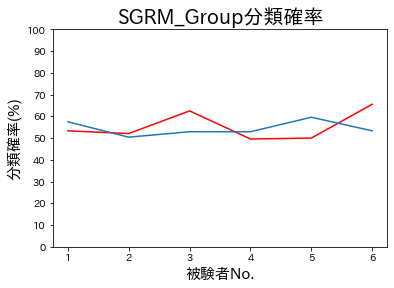

In [18]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SGRM_group_probability_K3.pdf")
plt.show()